# Lesson on CNN

## Learning a Pattern
In this example, we will see how we can create a simple CNN that *learns to recognize an arbitrary pattern*.

Then we will see if such a network can learn also to repair a broken pattern.

Finally, we will see some real-life applications of CNN to genomic medicine, and we will look into its details in the next practical lesson.

### Keras: the library for the neural networks
[Keras](https://keras.io/) is a python library that offers high-level APIs to Tensorflow: we will use this to build our model, using the `Sequential` model class. Since it is a classifier CNN, we will be using both `Dense` and `Conv1d` layers.

We will also use the `print_summary`, a function usefull for displaying the built model.

If you need to install it, just run in your terminal the following:
```bash
pip install keras
```

In [1]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Conv1D,InputLayer,GlobalAveragePooling1D
from keras.utils import print_summary

Using TensorFlow backend.


### Matplotlib: the library for plottings graphs
[Matplotlib](https://matplotlib.org/) will be the library we will be using for plotting graphs.

In [2]:
from matplotlib.colors import cnames
import matplotlib.pyplot as plt

### Numpy & Sklearn: time-saver libraries
[Numpy](https://docs.scipy.org/doc/numpy/index.html) and [Sklearn](https://scikit-learn.org/stable/) are two libraries that we will be use extensively to quickly write some complex functions, such as generating and splitting the dataset.

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

### Utilities
We will use [tqdm](https://github.com/tqdm/tqdm) to visualize the training progress and typing to help understand which type of variables go in and out of functions.

In [4]:
from tqdm import tqdm_notebook as tqdm
from keras_tqdm import TQDMNotebookCallback as ktqdm
from typing import Tuple, Callable

### Resetting the random seed
To be able to reproduce the results, since some elements are initialized via random extractions, it is important to set the random seed as follows:

In [5]:
import os
import random
import tensorflow as tf

In [6]:
def set_seed(seed:int):
    """Set the random state of the various random extractions.
        seed:int, the seed to set the random state to.
    """
    np.random.seed(seed)
    random.seed(seed)
    tf.set_random_seed(seed)

### Quiet down some known library warnings
The tensorflow and Keras library are slightly out of tune for some functions, so tensorflow may rise some warnings. We will not worry about them and we are going to silence them as follows:

In [7]:
tf.logging.set_verbosity(tf.logging.ERROR)

## Creating the dataset
We will create the pattern's dataset as in the MLP lesson, by creating an *unknown* function that describes the signal of the pattern.

In [8]:
def black_box(x:np.ndarray)->np.ndarray:
    return np.round((3*np.sin(x))**2).astype(int)

In [9]:
def noise(x:np.ndarray)->np.ndarray:
    return np.round(np.random.uniform(low=0, high=9, size=x.size)).astype(int)

### What does our signal look like?
Keeping in mind that the signal is actually unknown, to help understanding the data we can plot the `black_box` function:

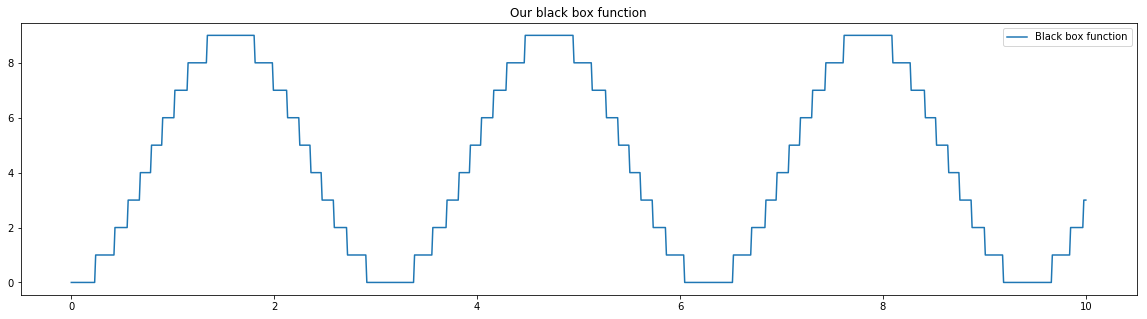

In [10]:
def plot_black_box():
    plt.figure(figsize=(20, 5))
    x = np.linspace(0,10, num=1000,endpoint=True)
    y = black_box(x)
    plt.plot(x,y, label='Black box function')
    
plot_black_box()
plt.title("Our black box function")
plt.legend()
plt.show()

## What does noise look like?

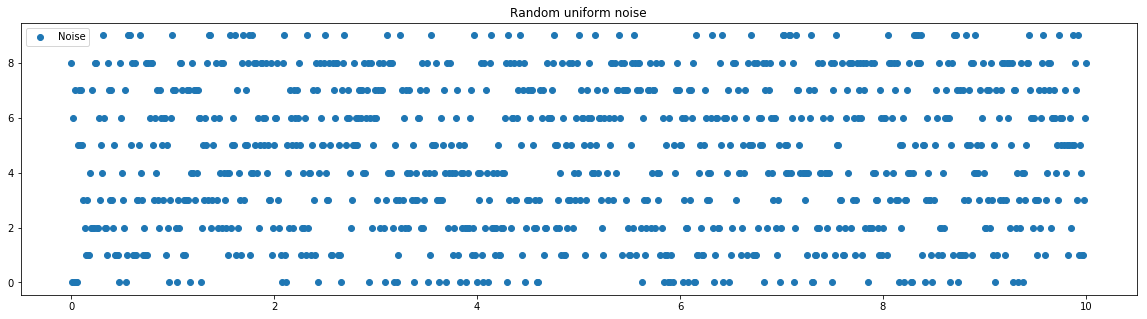

In [11]:
def plot_noise():
    plt.figure(figsize=(20, 5))
    x = np.linspace(0,10, num=1000,endpoint=True)
    y = noise(x)
    plt.plot(x,y, "o", label='Noise')
    
plot_noise()
plt.title("Random uniform noise")
plt.legend()
plt.show()

## Creating the pattern
Now we can convert the signal into a repeating pattern:

In [12]:
def pattern(window:int, callback:Callable, MAX:int=10):
    return 8+callback(np.linspace(MAX*(window-1), MAX*window, num=50))

In [13]:
def patterns(N:int, callback:Callable):
    return np.array([
        pattern(i, callback) for i in np.random.randint(10000, size=N)
    ])

### Visualizing the pattern
We can now finally proceed to visualize what our pattern looks like:

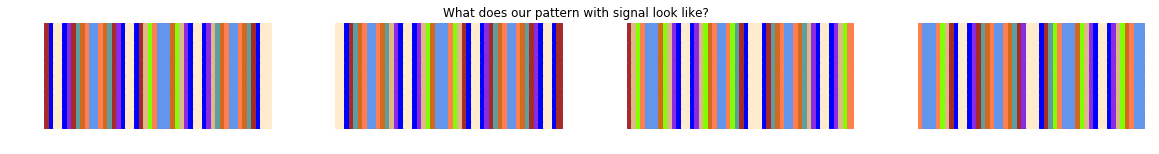

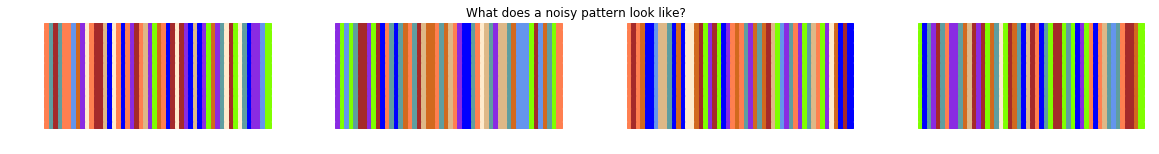

In [14]:
colors = list(cnames)

def get_color(i:int):
    return colors[i]

def plot_pattern(pattern, ax=plt):
    ax.set_axis_off()
    for i, c in enumerate(pattern):
        for j in np.linspace(0,10, num=16):
            ax.plot(i, j, "s", color=get_color(c))

_, axes = plt.subplots(1, 4, figsize=(20,2))
for i in tqdm(range(4)):
    plot_pattern(pattern(i, black_box), axes[i])
plt.suptitle("What does our pattern with signal look like?")
plt.show()
_, axes = plt.subplots(1, 4, figsize=(20,2))
for i in tqdm(range(4)):
    plot_pattern(pattern(i, noise), axes[i])
plt.suptitle("What does a noisy pattern look like?")
plt.show()

## Finally generating the dataset

In [15]:
signal_datapoints_percentage = 0.1
noisy_datapoints_percentage = 1 - signal_datapoints_percentage
total_datapoints = 100
signal_datapoints = np.round(total_datapoints*signal_datapoints_percentage).astype(int)
noisy_datapoints = np.round(total_datapoints*noisy_datapoints_percentage).astype(int)
set_seed(42)
encoder = OneHotEncoder(categories='auto', sparse=False)
dataset = np.vstack([
    np.hstack([
        patterns(signal_datapoints, black_box),
        np.ones((signal_datapoints, 1))
    ]),
    np.hstack([
        patterns(noisy_datapoints, noise),
        np.zeros((noisy_datapoints, 1))
    ])
])
x, y = encoder.fit_transform(dataset[:,:50]).reshape(total_datapoints, 50, 10), dataset[:,50:].flatten()

## Splitting the dataset: training and testing set

To train our network we will be using a portion of the sampled datapoints extracted via a random uniform distribution called **training set** and we will evaluate the obtained models using the **testing set**.

The two dataset will have size $0.7$ and $0.3$ respectively.

To split the dataset in two we will use the function `train_test_split` from the sklearn package, to which we will also set the parameter `random_state`: the extraction is randomized, but we want to be able to reproduce the results, so for every given random_state we will obtain a fixed dataset split.

In [16]:
def split_dataset(dataset:Tuple[np.ndarray, np.ndarray], seed:int, test_size:float=0.3)->Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Return the given dataset split among training a test set for the given random seed.
        dataset:Tuple[np.ndarray, np.ndarray], 
        seed:int, 
    """
    return train_test_split(*dataset, test_size=test_size, random_state=seed)

## Creating the Convolutional Neural Network model

We will now finally proceed to create a simple CNN model, composed by the following layers:

- **Input layer:** as much neurons as the input size, in our example $50$, with ReLu activation function. 
- **Conv1D Hidden layers:** `depth` Conv1D layers with ReLu activation function, each one with `breath` neurons.
- **MLP Hidden layers:** 2 Dense layers with ReLu activation function with 10 neurons.
- **Output layer:** one neuron, Dense layer, with Sigmoid activation function. 

![CNN](CNN.png)

Here's a schema of a Convolutional Layer with kernel size $3$:
![Convolutional Layer](Conv1d.png)

### Loss function
As loss function we will be using the **[binary crossentropy](https://keras.io/losses/)** (MSE):
$$-\frac{1}{N} \sum_{i=1}^{N}\left[y_{i} \log \left(\hat{y}_{i}\right)+\left(1-y_{i}\right) \log \left(1-\hat{y}_{i}\right)\right]$$
Where $N$ is the number of examples, $y_i$ is the true value and $\widehat{y}_i$ is the predicted one.
### Optimizer
As optimizer we will be using the **[Stochastic gradient descent](https://keras.io/optimizers/)**, in its mini-batched version. This optimizer updates the weights after each mini-batch using the average loss partial derivative:
$$w_{i, j} \leftarrow w_{i, j}-\eta_{t} \frac{1}{\left|S_{t}\right|} \sum_{s \in S_{t}} \frac{\partial \ell_{s}(W)}{\partial w_{i, j}}$$
where \(S_t\) is a subset of fixed cardinality extracted from the training set and $\eta_{t}$ is a step coefficient, which can either be constant or be defined by a function, for example, often, as a momentum.

In [17]:
def auroc(y_true, y_pred):
    score = tf.metrics.auc(y_true, y_pred, curve="ROC", summation_method="careful_interpolation")[1]
    K.get_session().run(tf.local_variables_initializer())
    return score

def auprc(y_true, y_pred):
    score = tf.metrics.auc(y_true, y_pred, curve="PR", summation_method="careful_interpolation")[1]
    K.get_session().run(tf.local_variables_initializer())
    return score


def cnn(breath:int, deapth:int, kernel_size:int, input_size:int, random_state:int=42):
    """Return a convolutional neural network with `deapth` hidden layers, each one with `breath` neurons.
        breath:int, number of neurons per hidden layer.
        deapth:int, number of hidden layers.
        random_state:int, seed to initializing weights.
    """
    set_seed(random_state)
    model = Sequential([
        InputLayer(input_shape=input_size),
        *[Conv1D(breath, kernel_size, activation="relu") for i in range(deapth)],
        GlobalAveragePooling1D(),
        *[Dense(4, activation="relu") for i in range(1)],
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer='nadam',
        loss='binary_crossentropy',
        metrics=[auroc, auprc, 'accuracy']
    )
    return model

In [18]:
def fit(model:Sequential, x_train:np.ndarray, x_test:np.ndarray, y_train:np.ndarray, y_test:np.ndarray, epochs:int, initial_epoch:int, batch_size:int):
    """Train the given model on given train data for the given epochs number.
        model:Sequential, the model to be trained.
        x_train:np.ndarray, the input for training the model.
        x_test:np.ndarray, the input for testing the model.
        y_train:np.ndarray, the output labels for training the model.
        y_test:np.ndarray, the output labels for testing the model.
        epochs:int, number of epochs for which to train the model.
        initial_epoch:int, starting epoch.
        batch_size:int, number of datapoints per training batch.
    """
    return model.fit(
        x_train,
        y_train,
        shuffle=True,
        verbose=0,
        #callbacks=[ktqdm(metric_format="{name}: {value:e}", leave_outer=False)],
        validation_data=(x_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        initial_epoch=initial_epoch
    )

In [19]:
def plot_history(history):
    _, axes = plt.subplots(1, 4, figsize=(20,5))
    for i, (name, index) in enumerate({
        "Accuracy":"acc",
        "Loss":"loss",
        "AUROC":"auroc",
        "AUPRC":"auprc"
    }.items()):
        testing_index = "val_{index}".format(index=index)
        axes[i].plot(history[index], label='Training {label} = {value:0.6f}'.format(
            label=name,
            value=history[index][-1]))
        axes[i].plot(history[testing_index] , label='Testing {label} = {value:0.6f}'.format(
            label=name,
            value=history[testing_index][-1]))
        axes[i].set_ylabel(name)
        axes[i].set_title(name)
        axes[i].set_xlabel('Epochs')
        axes[i].legend()
    plt.suptitle("Training history after {epochs} epochs.".format(epochs=len(history["acc"])))
    plt.show()
    
def chain_histories(new_history, old_history):
    if old_history is None:
        return new_history
    return {
        key: old_history[key] + new_history[key] for key in old_history
    }

In [20]:
base_epochs = 25
steps = 5
batch_size = 4
breath, deapth = 4, 2

In [21]:
our_first_model = cnn(breath, deapth, 5, (50, 10))
print_summary(our_first_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 46, 4)             204       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 42, 4)             84        
_________________________________________________________________
global_average_pooling1d_1 ( (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 313
Trainable params: 313
Non-trainable params: 0
_________________________________________________________________


In [22]:
x_train, x_test, y_train, y_test = split_dataset((x, y), 42)

In [23]:
def get_epochs(step, epochs):
    return (step+1)*epochs

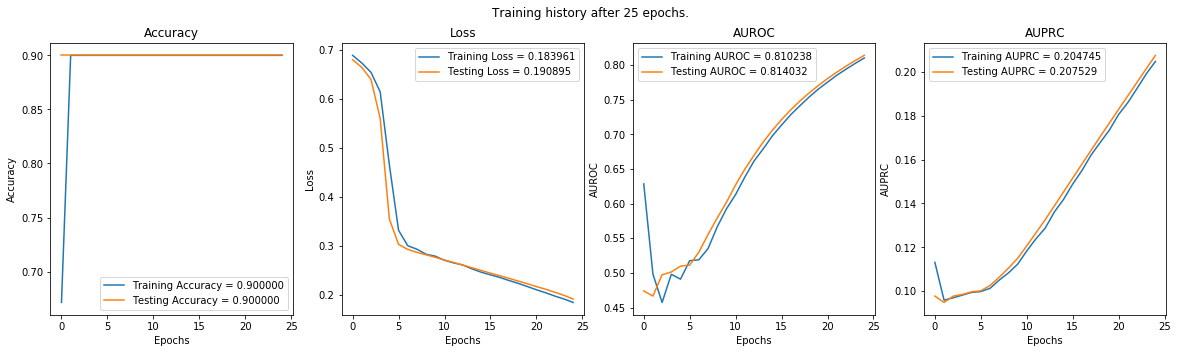

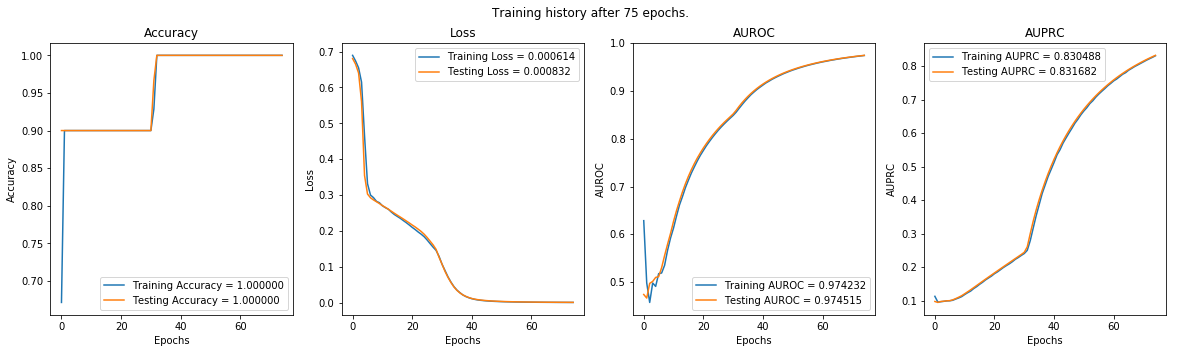

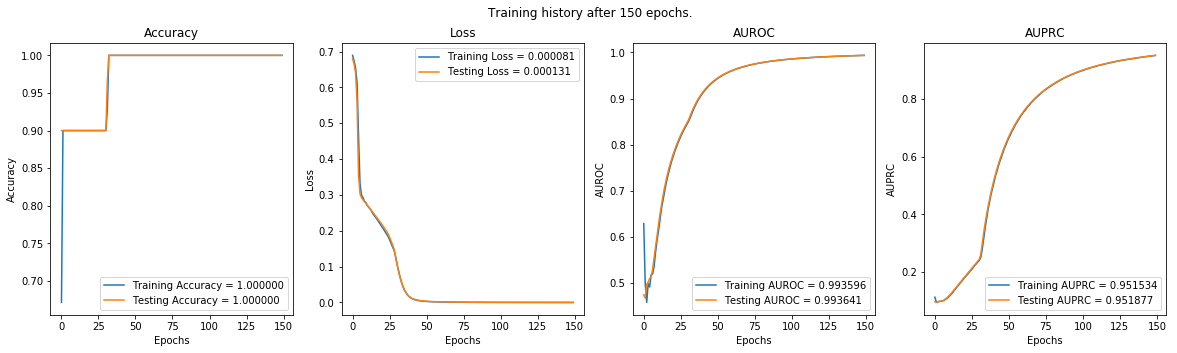

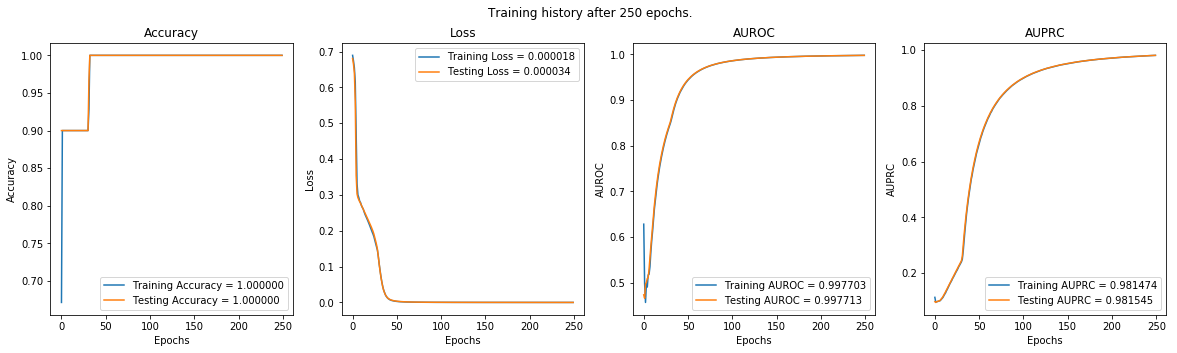

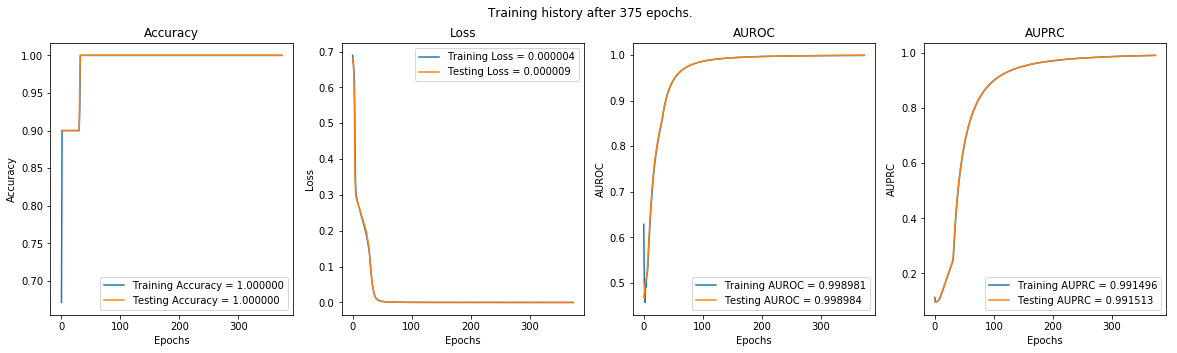

In [24]:
total_epochs = 0
history = None
for step in tqdm(range(steps)):
    epochs = get_epochs(step, base_epochs)
    history = chain_histories(fit(
        our_first_model,
        x_train,
        x_test,
        y_train,
        y_test,
        epochs+total_epochs,
        total_epochs, 
        batch_size
    ).history, history)
    total_epochs+=epochs
    plot_history(history)

## Repairing a pattern
If it ain't broken, don't fix it. So, let's break the pattern function:

In [25]:
def apply_noise(y:np.ndarray)->np.ndarray:
    mask = np.random.randint(low=0, high=10, size=y.size) > 8
    y[mask] = noise(y)[mask]
    return y.astype(int)

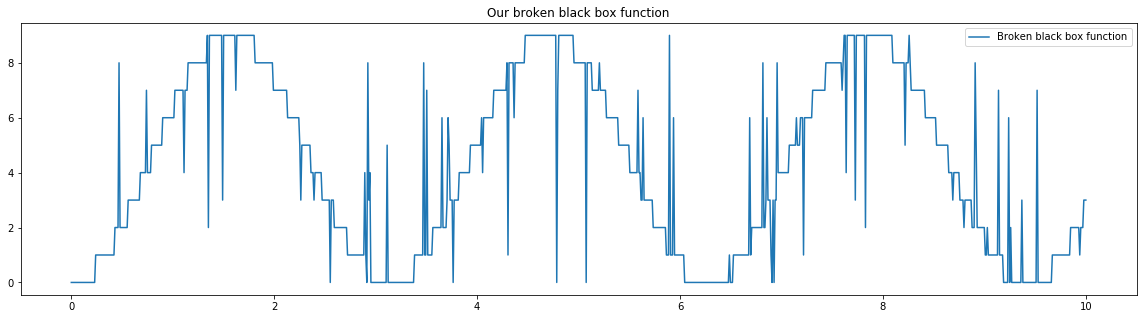

In [26]:
def plot_broken_black_box():
    plt.figure(figsize=(20, 5))
    x = np.linspace(0,10, num=1000,endpoint=True)
    y = apply_noise(black_box(x))
    plt.plot(x,y, label='Broken black box function')
    
plot_broken_black_box()
plt.title("Our broken black box function")
plt.legend()
plt.show()

In [27]:
def repairing_cnn(breath:int, deapth:int, kernel_size:int, input_size:int, random_state:int=42):
    """Return a convolutional neural network with `deapth` hidden layers, each one with `breath` neurons.
        breath:int, number of neurons per hidden layer.
        deapth:int, number of hidden layers.
        random_state:int, seed to initializing weights.
    """
    set_seed(random_state)
    model = Sequential([
        InputLayer(input_shape=input_size),
        *[Conv1D(breath, kernel_size, activation="relu") for i in range(deapth)],
        GlobalAveragePooling1D(),
        Dense(input_size[0], activation="sigmoid")
    ])
    model.compile(
        optimizer='nadam',
        loss='binary_crossentropy',
        metrics=[auroc, auprc, 'accuracy']
    )
    return model

In [28]:
total_datapoints = 100
steps = 5
y = patterns(total_datapoints, black_box)
noisy = np.array([
    apply_noise(line) for line in y
])

input_size = (50, len(set(noisy.ravel().tolist())))
x = encoder.fit_transform(y.reshape(-1, 1)).reshape(total_datapoints, *input_size)

x_train, x_test, y_train, y_test = split_dataset((x, y/np.max(y)), 42)

In [29]:
our_repairing_model = repairing_cnn(breath, deapth, 5, input_size)
print_summary(our_repairing_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 46, 4)             364       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 42, 4)             84        
_________________________________________________________________
global_average_pooling1d_2 ( (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                250       
Total params: 698
Trainable params: 698
Non-trainable params: 0
_________________________________________________________________


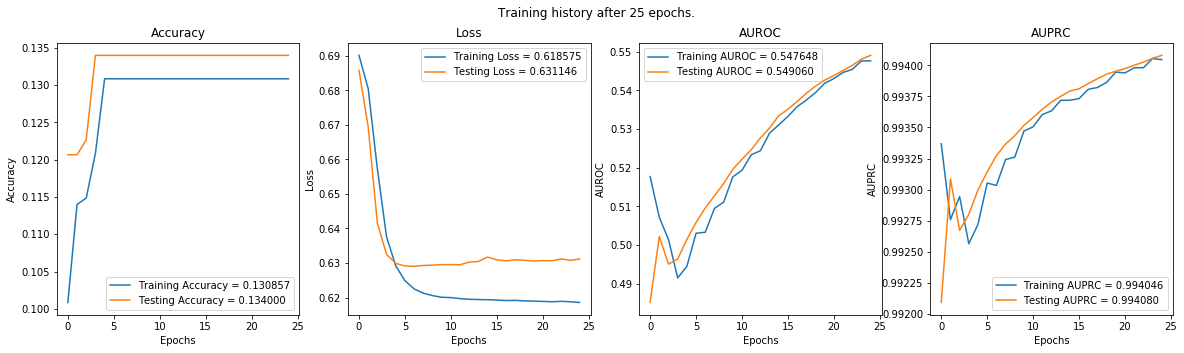

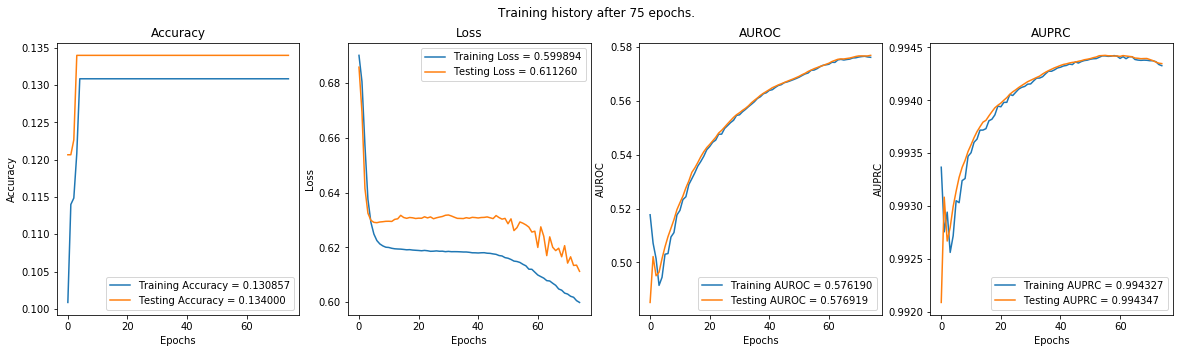

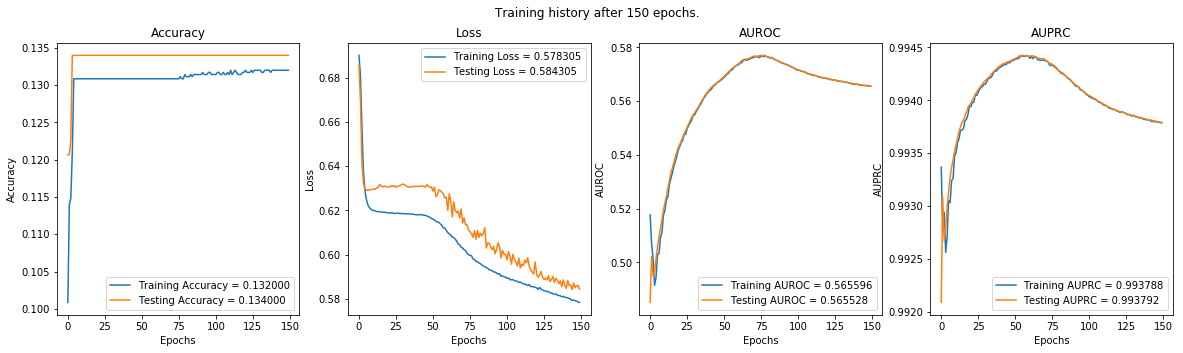

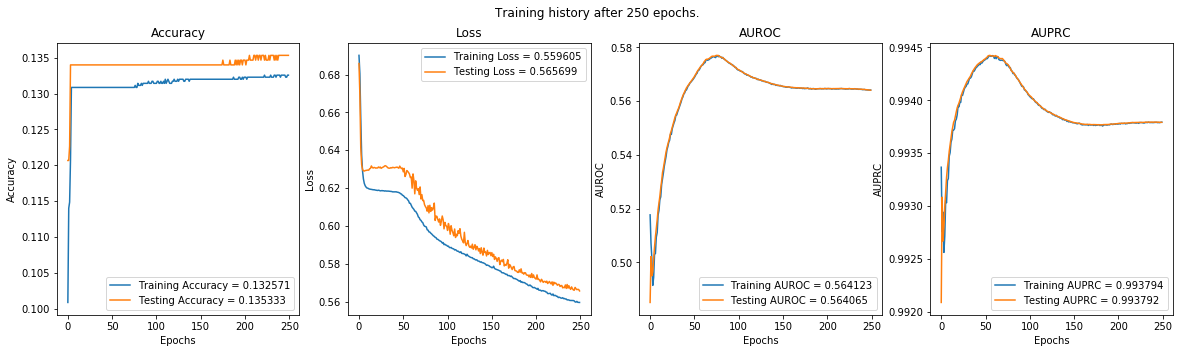

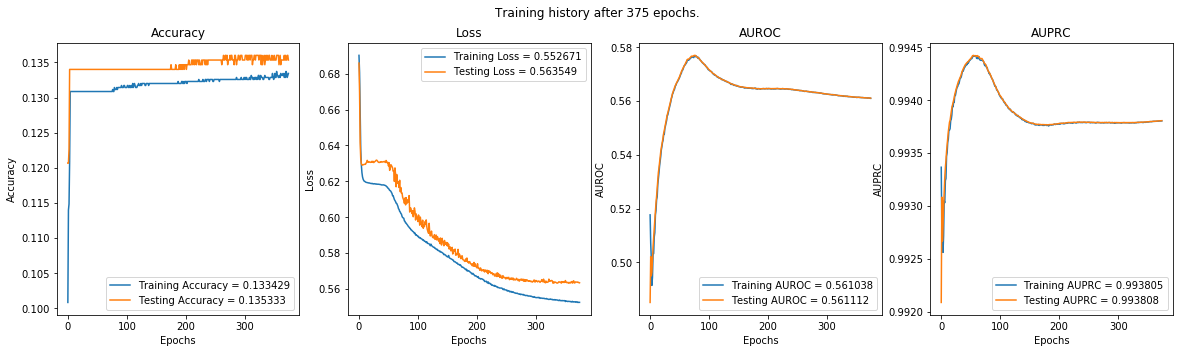

In [30]:
total_epochs = 0
history = None
for step in tqdm(range(steps)):
    epochs = get_epochs(step, base_epochs)
    history = chain_histories(fit(
        our_repairing_model,
        x_train,
        x_test,
        y_train,
        y_test,
        epochs+total_epochs,
        total_epochs, 
        batch_size
    ).history, history)
    total_epochs+=epochs
    plot_history(history)

## Quale metrica conviene seguire? Perchè?